# Generating input files
#### These files need to be generated for the main simulation. 

These functions serve to illustrate, how simple input files can be generated. The functions can be used all together to build a complete set of input files (e.g. when user wants to test various hypothesis on simple demographies), or individually to supply missing input files (e.g. when user already has demography data, but needs to build migration list). 

The main parameters to build a set of input files are: the number of rows and columns of the grid and the number of time points (T), average deme size N, and batch name to save the generated input files. All generated input files will use the batch name as prefix. 

### Demographic history


This file contains demographic history of the simulated population. It contains T rows (T different time points) of deme sizes for each cell in the grid (rows x columns). Empty cells have deme size 0.

Function *generate_final_map(rows, cols, N, map_type='homogenous')* can generate three types of final maps (demography in presence): homogeous, Poisson and uniform, with population sizes equal to N, or draws from Poisson or uniform distribution with mean N, respectively. Default map is homogenous. 

Function *generate_static(final_map, T, batch_name='')* generates demographis history with T identical rows (time points) as the final_map, saved into *batch_name+'lin_inc_N_'+str(N)+'.txt'*

Function *generate_lin_increase_data(final_map, T, batch_name='')* generates demographic history of demes increasing linearly from 0 or 1 to the final map over T time points, saved into *batch_name+'lin_inc_N_'+str(N)+'.txt'*. 


### Migration list

Function generate_migration_list(rows, cols, m=0.1, batch_name='') generates migration list for specified grid geometry, assuming that migration occurs between adjacent cells symmetrically (classic stepping stone model).  By default migration rate is specified to 0.1. 

The list is saved in *batch_name+'mig_list'+str(m)+'.txt'* and can be manually edited, if user wants to model more complex migration scenarios (e.g. migration barriers). 


### Sample list

Function *generate_sample_list(rows, cols,s=0.5, batch_name='')* randomly samples fraction *s* of all cells without repetition (2 samples are taken from each sampled grid cell by gridCoal simulator), saving it to *batch_name+'sample_list.txt'*. Note that if the sampled cells are empty at the final time point, this results in an arror. User needs to manually edit the tst file to remove these sample numbers, accoridng to their own input demographic history data. 

If no sample list is specified for gridCoal, it automatically samples all non-zero cells.  




### Ancestral population list
Function *generate_ancestral_pop(rows, cols, batch_name='')* generates a vector with lengh n (grid size) of ones (all demes originating in a single population), saving it to 'batch_name_anc_pop.tsv'. 



In [12]:
import csv
import numpy as np
import timeit
from pathlib import Path
import random
import matplotlib.pyplot as plt
%matplotlib inline  

In [13]:
rows = 5   #number of rows
cols = 4   #number of columns
T = 10 #number of time steps
gt=2  #generation time
dt=20 # time between defined time steps
N=10  #average population size
mu=0.1 #migration rate between neighbouring demes
s = 0.5 # s is coverage - fraction of sampled grid cells. Note that using this function may include 
#some that are empty in the input data, which will cause error. Check before submitting for simulations. 

batch_name = 'example_simple_exp_'  #prefix used for input data associated with this simulation

In [19]:
def generate_final_map(rows, cols, N, map_type='homogenous'):
    ## this function can generate 3 types of final map, with individual deme sizes drawn from uniform 
    ## or Poisson distribution, or homogenous map with equal sized demes. It also plots the map. 
    
    if map_type =='homogenous':
        final_map=[N]*(cols*rows)  #identical deme sizes
    elif map_type =='Poisson':
        final_map=np.around(np.random.poisson(N,[rows*cols])) #data drawn from poisson distribution
    elif map_type =='uniform':
        final_map=np.around(np.random.uniform(0,2*N,[rows*cols]))  #data drawn from uniform distribution
    else: 
        print ('Unknown type')
    final_map_2D=np.reshape(final_map, [rows, cols])
    plt.pcolor(final_map_2D)
    return (final_map)
    
def generate_lin_increase_data(final_map, T, batch_name=''):
    ## this function generates linear increase from size 1 to the final map over T time points
    demography_data=[]
    for i in range (T):
        this_timepoint=np.around((1.0+i)*final_map/T)
        demography_data.append(this_timepoint)
    demography_data=np.array(demography_data)
    np.savetxt(batch_name+'lin_inc_N_'+str(N)+'.txt', demography_data,  fmt='%1d', delimiter='\t')

    return (demography_data.astype(int))  

def generate_static(final_map, T, batch_name=''):
    ## this function generates static demograhy for a final map over T time points
    demography_data=[]
    for i in range (T):
        this_timepoint=final_map.copy()
        demography_data.append(this_timepoint)
    demography_data=np.array(demography_data)
    np.savetxt(batch_name+'static_N_'+str(N)+'.txt', demography_data,  fmt='%1d', delimiter='\t')

    return (demography_data.astype(int))

def generate_migration_list(rows, cols, m=0.1, batch_name=''):
    n = rows*cols
    add_mat = np.zeros([n,n])
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            # Two inner diagonals
            if c > 0: add_mat[i-1,i] = add_mat[i,i-1] = 1
            # Two outer diagonals
            if r > 0: add_mat[i-cols,i] = add_mat[i,i-cols] = 1
    m_list=[]
    for i in range(n):
        for j in range (n):
            if add_mat[i,j]==1:
                m_list.append([int(i),int(j),m])
    m_list=np.array(m_list) 
    np.savetxt(batch_name+'mig_list'+str(m)+'.txt', m_list, fmt= ['%i','%i','%4.2e'])
    return m_list
 
def generate_sample_list(rows, cols,s=0.5, batch_name=''):
    
    grid_size=rows*cols
    samples=int(grid_size*s)
    mr=range(0,grid_size,1)
    sample_list= (random.sample(range(0,grid_size,1), samples))
    sample_list.sort()
    np.savetxt(batch_name+'sample_list.txt',sample_list,  fmt='%1d', delimiter='\t')
    return sample_list

def generate_ancestral_pop(rows, cols, batch_name=''):
    ancestral_pop=[]
    for i in range(rows*cols):
        ancestral_pop.append(1)
    np.savetxt(batch_name+'anc_pop.txt', ancestral_pop, fmt= '%i')
    return ancestral_pop

def generate_ancestral_pop_sizes(test_data_T=1, batch_name=''):
    if type(test_data_T)==int:
        anc_pop_size=1
        f = open(batch_name+'anc_pop_size_1.tsv', 'w')
        
    else:
        last_datapoint=test_data_T[-1]  #make this changable
        anc_pop_size=sum(last_datapoint)
        f = open(batch_name+'anc_pop_size_sum.tsv', 'w')
    

    f.write(str(anc_pop_size))
    f.close()


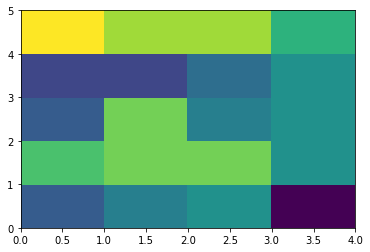

In [20]:
final_map = generate_final_map(rows, cols, N, 'Poisson')   #generate final map

In [21]:
my_demography=generate_lin_increase_data(final_map, T, batch_name)  #generate linear increasing pop sizes leading to final map

In [22]:
mig_list= generate_migration_list(rows, cols, mu, batch_name)
sample_list=generate_sample_list(rows, cols,0.5, batch_name)
ancpop_list=generate_ancestral_pop(rows, cols, batch_name=batch_name )

In [24]:
print ('Final map', final_map)
print ('Demography', my_demography)
print ('Migration list', mig_list)
print ('Sampled cells', sample_list)
print ('Ancestral populations', ancpop_list)


Final map [ 7  9 10  3 13 14 14 10  7 14  9 10  6  6  8 10 17 15 15 12]
Demography [[ 1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  1]
 [ 1  2  2  1  3  3  3  2  1  3  2  2  1  1  2  2  3  3  3  2]
 [ 2  3  3  1  4  4  4  3  2  4  3  3  2  2  2  3  5  4  4  4]
 [ 3  4  4  1  5  6  6  4  3  6  4  4  2  2  3  4  7  6  6  5]
 [ 4  4  5  2  6  7  7  5  4  7  4  5  3  3  4  5  8  8  8  6]
 [ 4  5  6  2  8  8  8  6  4  8  5  6  4  4  5  6 10  9  9  7]
 [ 5  6  7  2  9 10 10  7  5 10  6  7  4  4  6  7 12 10 10  8]
 [ 6  7  8  2 10 11 11  8  6 11  7  8  5  5  6  8 14 12 12 10]
 [ 6  8  9  3 12 13 13  9  6 13  8  9  5  5  7  9 15 14 14 11]
 [ 7  9 10  3 13 14 14 10  7 14  9 10  6  6  8 10 17 15 15 12]]
Migration list [[ 0.   1.   0.1]
 [ 0.   4.   0.1]
 [ 1.   0.   0.1]
 [ 1.   2.   0.1]
 [ 1.   5.   0.1]
 [ 2.   1.   0.1]
 [ 2.   3.   0.1]
 [ 2.   6.   0.1]
 [ 3.   2.   0.1]
 [ 3.   7.   0.1]
 [ 4.   0.   0.1]
 [ 4.   5.   0.1]
 [ 4.   8.   0.1]
 [ 5.   1.   0.1]
 [ 5.   4.   0.1]
 